## Computer Vision (EECE 7219) Assignment #3
### University of Memphis, Spring 2023
#### Instructor: Dr. Yeasin

Bereket Kebede, Gradaute Student, EECE

## Projection Matrix based calibration

Projection Matrix based calibration 

- Use the method in Assignment 1 to detect points or blobs
- Use epipolar line to find establish correspondence (slide 6)
- Write a computer program to construct the linear system of
equation (see slide 7) using corresponding points.
- Use algorithm in Slide 7 to compute the Fundamental Matrix
- Compute the extrinsic parameter (Essential matrix) from fundamental matrix (see slide 8).
- Use the Intrinsic parameter from software assignment 2.
- Perform 3D dense reconstruction

## Getting Started
-----

In [1]:
#import necessary libaries

import sys
sys.path.append("C:/Users/CIRL/AppData/Local\Programs/Python/Python39/Lib/site-packages")
sys.path.append("C:/Users/CIRL/AppData/Local\Programs/Python/Python36/Lib/site-packages")

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import yaml

## Use epipolar line to find establish correspondence (slide 6)


Epipolar lines: where this epipolar plane intersects the two image planes

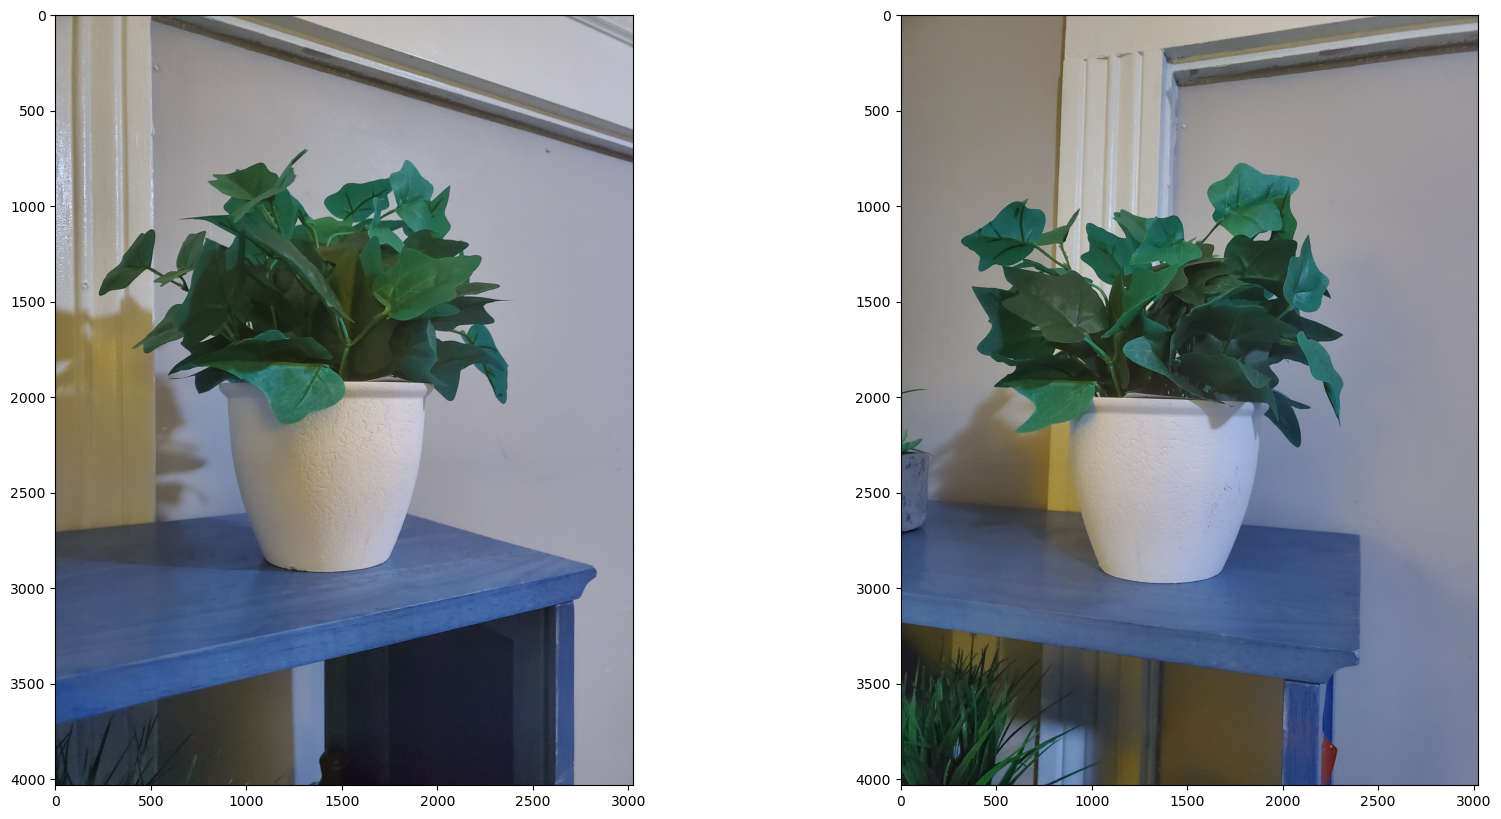

In [2]:
img1 = cv2.imread('left.jpg')
img2 = cv2.imread('right.jpg')

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(img1, cmap='gray')
plt.subplot(122)
plt.imshow(img2, cmap='gray')

plt.show()

In [3]:
# Use class for extracting keypoints and computing descriptors using the Scale Invariant Feature Transform (SIFT) in 2D
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1_org = []
pts2_org = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.95*n.distance:
        pts2_org.append(kp2[m.trainIdx].pt)
        pts1_org.append(kp1[m.queryIdx].pt)

In [4]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c, d = img1.shape
#     img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
#     img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,8)
        img1 = cv2.circle(img1,tuple(pt1),40,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),40,color,-1)
    return img1,img2

In [5]:
pts1 = np.int32(pts1_org)
pts2 = np.int32(pts2_org)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

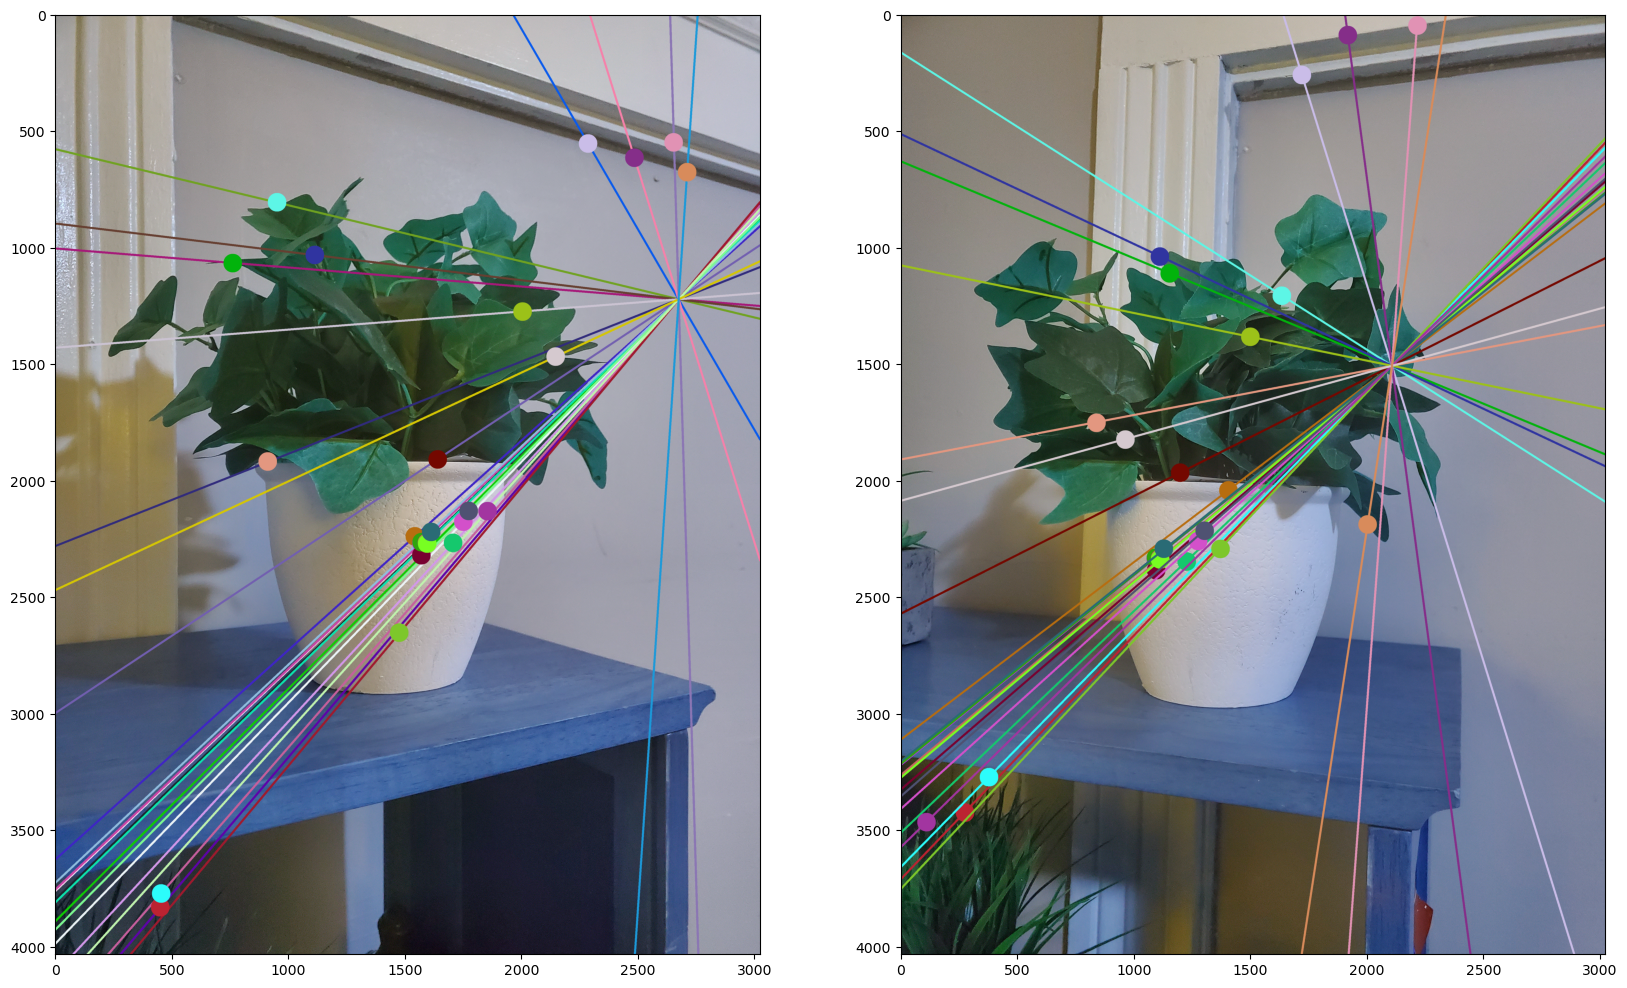

In [6]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(20, 20))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

## Fundamental Matrix

In [7]:
F

array([[ 2.46888906e-07,  1.03483253e-06, -1.92666339e-03],
       [-8.04365336e-07,  1.02451343e-07,  2.02593211e-03],
       [ 6.93676247e-04, -2.33325563e-03,  1.00000000e+00]])

In [8]:
# camera matrix from assignment 2
camera_matrix = np.array([ [2.50739342e+03, 0.00000000e+00, 1.31135566e+03], [0.00000000e+00,2.47389326e+03,8.39797738e+02], [0,0,1]])
camera_matrix

array([[2.50739342e+03, 0.00000000e+00, 1.31135566e+03],
       [0.00000000e+00, 2.47389326e+03, 8.39797738e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

## Extrinstic Matrix

Compute the extrinsic parameter (Essential matrix) from fundamental matrix (see slide 8).

Essential matrix: Essential Matrix E = RS, a natural link between the stereo point pair and the extrinsic parameters of the stero system.

- Essential matrix is defined in terms of camera co-ordinates
- Fundamental matrix defined in terms of pixel co-ordinates

Where R is rotation matrix and S is 

\begin{matrix}
0 & -T_z & T_y\\
T_z & 0 & -T_x\\
-T_y & T_x & 0\\
\end{matrix}



![title](Slide_9.png)

In [30]:
print(len(pts1_org))
print(len(pts2_org))

# choosing only inliners
print(len(pts1))
print(len(pts2))

3784
3784
26
26


In [29]:
#ess_mat = cv2.findEssentialMat(pts1_org[0], pts2_org[1], camera_matrix)
ess_mat = cv2.findEssentialMat(pts1, pts2, camera_matrix)
ess_mat[0]


array([[-0.12555913,  0.42126081, -0.08724594],
       [ 0.23154465,  0.10368011, -0.6471149 ],
       [-0.2302579 ,  0.50580512,  0.08476242]])

## Disparity Map

Depth map from stereo vision

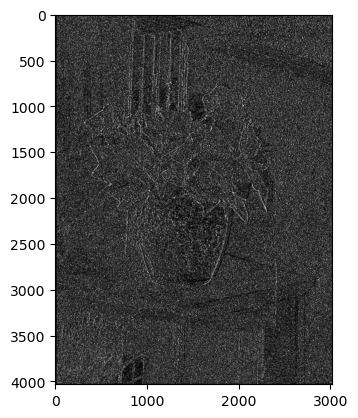

In [8]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
imgL = cv.imread('left.jpg', cv.IMREAD_GRAYSCALE)
imgR = cv.imread('right.jpg', cv.IMREAD_GRAYSCALE)
stereo = cv.StereoBM_create(numDisparities=16, blockSize=5)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

## References

[1]  https://people.scs.carleton.ca/~c_shu/Courses/comp4900d/notes/review2.pdf